<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de películas para que el sistema determine si la evaluación es positiva o negativa (sentiment analysis como clasificador binario de texto)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2022-06-12 15:08:47--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2022-06-12 15:08:47--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2022-06-12 15:08:47 (14.9 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2022-06-12 15:08:47--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.002s (14.9 MB/s)


In [6]:
from torch_helpers import binary_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = binary_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).next()
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = binary_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset críticas de películas de IMDB puntuadas deforma positiva o negativa.\
Referencia del dataset: [LINK](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [7]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('imdb_dataset.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1fXW-u9NVbH1yhwU1AHzPVtgGyV1c8N3g'
    output = 'imdb_dataset.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1fXW-u9NVbH1yhwU1AHzPVtgGyV1c8N3g
To: /content/imdb_dataset.csv
100%|██████████| 66.2M/66.2M [00:00<00:00, 101MB/s] 


In [8]:
# Armar el dataset
df = pd.read_csv('imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1 - Limpieza de datos
- En los datos se observo que en la columna "review" hay código HTML de salto de línea.
- Tranformar la columna snetiment a 0 y 1



In [9]:
# En los datos se observó código de HTML de salto de línea <br />
import re
df_reviews = df.copy() 
df_reviews['review'] = df['review'].apply(lambda x: re.sub("<br />", "", x))
df_reviews['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

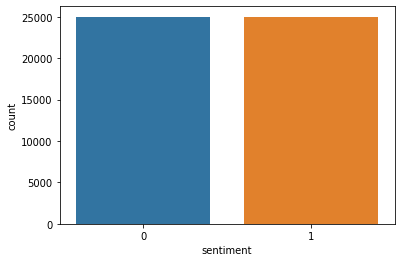

In [11]:
# Observar como está distribuido el dataset
sns.countplot(x='sentiment', data=df_reviews)
plt.show()

Se puede observar que el dataset está perfectamente balanceado

In [12]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['review'].values
text_sequences.shape

(50000,)

In [13]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

50000

In [14]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [15]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

64309862

In [16]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from torch_helpers import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [17]:
# Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'oz',
 'episode',
 "you'll",
 'be',
 'hooked',
 'they',
 'are',
 'right']

In [18]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

11546955

In [19]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [20]:
# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

126512

In [21]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [22]:
sequences[0][:10]

[26, 4, 1, 78, 44, 1071, 11, 99, 146, 38]

In [23]:
# Determinar cual es la oración más larga
max(len(s) for s in sequences)

1853

In [24]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from torch_helpers import pad_sequences
maxlen = 200

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [25]:
# Observar las dimensiones de la variable input
X.shape

(50000, 200)

In [26]:
# Tomar la columna rating y alcemacenarla en una variable "y"
# Su shape debe ser equivalente la cantidad de rows del corpus
y = df_reviews['sentiment'].values
print(y.shape)

(50000,)


In [27]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # la loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 200
Output dim 1


In [36]:
# Utilizamos "random_split" para crear los datos de train y test
# partir del conjunto de datos_set
# Fijamos un "seed" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
torch.manual_seed(42)
data_set_reduced_size = int(data_set.len * 0.4)
valid_set_size = int(data_set_reduced_size * 0.2)
train_set_size = data_set_reduced_size - valid_set_size
data_set_reduced, _ = torch.utils.data.random_split(data_set, [data_set_reduced_size, data_set.len - data_set_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_reduced, [train_set_size, data_set_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Tamaño del conjunto de entrenamiento: 16000
Tamaño del conjunto de validacion: 4000


### 2 - Entrenar el modelo con Embeddings + LSTM

In [39]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.BCELoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─Embedding: 1-1                         [1, 200, 50]              100,050
├─LSTM: 1-2                              [1, 200, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 1]                    129
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 171,475
Trainable params: 171,475
Non-trainable params: 0
Total mult-adds (M): 12.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.69
Estimated Total Size (MB): 0.87

In [30]:
#from torchviz import make_dot
#make_dot(data_set.y, params=dict(list(model1.named_parameters()))).render("torchviz", format="png")

In [40]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=5
                )

Epoch: 1/5 - Train loss 0.623 - Train accuracy 0.648 - Valid Loss 0.510 - Valid accuracy 0.781
Epoch: 2/5 - Train loss 0.568 - Train accuracy 0.703 - Valid Loss 0.536 - Valid accuracy 0.688
Epoch: 3/5 - Train loss 0.512 - Train accuracy 0.748 - Valid Loss 0.556 - Valid accuracy 0.688
Epoch: 4/5 - Train loss 0.444 - Train accuracy 0.795 - Valid Loss 0.453 - Valid accuracy 0.844
Epoch: 5/5 - Train loss 0.382 - Train accuracy 0.833 - Valid Loss 0.303 - Valid accuracy 0.906


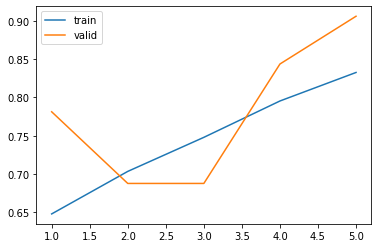

In [41]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [42]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:21<00:00, 137MB/s]


In [43]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [44]:
model_fasttext = FasttextEmbeddings()

In [45]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [48]:
class Model2(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size
        # embedding_dim = 300 --> dimensión de los embeddings utilizados
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

model2 = Model2(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.BCELoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1]                    --
├─Embedding: 1-1                         [1, 200, 300]             (600,000)
├─LSTM: 1-2                              [1, 200, 64]              126,976
├─Linear: 1-3                            [1, 128]                  8,320
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 1]                    129
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 735,425
Trainable params: 135,425
Non-trainable params: 600,000
Total mult-adds (M): 26.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.58
Params size (MB): 2.94
Estimated Total Size (MB): 3.53

In [49]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=5
                )

Epoch: 1/5 - Train loss 0.683 - Train accuracy 0.548 - Valid Loss 0.652 - Valid accuracy 0.594
Epoch: 2/5 - Train loss 0.653 - Train accuracy 0.602 - Valid Loss 0.587 - Valid accuracy 0.719
Epoch: 3/5 - Train loss 0.637 - Train accuracy 0.623 - Valid Loss 0.585 - Valid accuracy 0.781
Epoch: 4/5 - Train loss 0.623 - Train accuracy 0.644 - Valid Loss 0.583 - Valid accuracy 0.688
Epoch: 5/5 - Train loss 0.613 - Train accuracy 0.658 - Valid Loss 0.742 - Valid accuracy 0.625


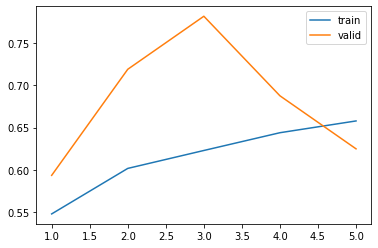

In [50]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

### 4 - Conclusión
El modelo con embeddings pre-entrenados terminó con menos accuracy que el anterior, pero hay que tener en cuenta que se realizaron muy pocas épocas de entrenamiento por el tiempo que demora el mismo.